In [1]:
from fastai import *
from fastai.vision import *

# Download and clean data

## from https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb


### Get a list of URLs
**Search and scroll**

Go to Google Images and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

It is a good idea to put things you want to exclude into the search query, for instance if you are searching for the Eurasian wolf, "canis lupus lupus", it might be a good idea to exclude other variants:

"canis lupus lupus" -dog -arctos -familiaris -baileyi -occidentalis

You can also limit your results to show only photos by clicking on Tools and selecting Photos from the Type dropdown.
Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press `Ctrl+Shift+J` in Windows/Linux and `Cmd+Opt+J` in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. Before running the following commands, you may want to disable ad blocking extensions (uBlock, AdBlockPlus etc.) in Chrome. Otherwise the window.open() command doesn't work. Then you can run the following commands:

```
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```


In [2]:
path = Path('bear_data/')

In [3]:
folder = 'grizzly'
file = folder+'.csv'
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)

download_images(path/file, dest, max_pics=200)

In [4]:
folder = 'teddy'
file = folder+'.csv'
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)

download_images(path/file, dest, max_pics=200)

In [5]:
folder = 'polar'
file = folder+'.csv'
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)

download_images(path/file, dest, max_pics=200)

In [6]:
folder = 'black'
file = folder+'.csv'
dest = path/folder
dest.mkdir(parents=True,exist_ok=True)

download_images(path/file, dest, max_pics=200)

In [7]:
classes = ['teddy','grizzly','polar','black']
for c in classes:
    print(c)
    verify_images(path/c, delete=True)

# View the images

In [8]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=32).normalize(imagenet_stats) # pct = percentage

In [9]:
data.classes

['black', 'grizzly', 'polar', 'teddy']

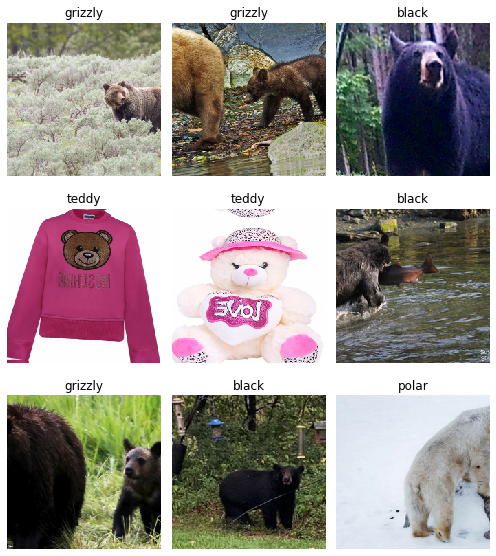

In [10]:
data.show_batch(rows=3,figsize=(7,8))

In [11]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'polar', 'teddy'], 4, 589, 147)

# Train Model

In [12]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [13]:
learn.fit_one_cycle(4)

In [14]:
learn.save('bear-stage-1')

In [20]:
learn.lr_find??

# Optimize learning by unfreezing and the fine tuning

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


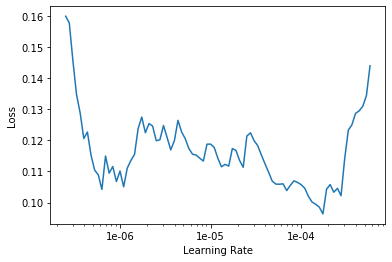

In [19]:
learn.unfreeze()
learn.lr_find(start_lr=1e-7,end_lr=1e-3)
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(2,max_lr=slice(5e-7,1e-6))
learn.save('bear-stage-2')

# Interpret and Cleanup

In [ ]:
learn.load('bear-stage-2')

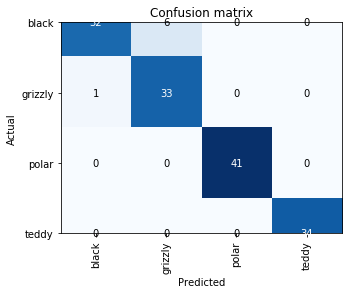

In [22]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. We can do this with .from_toplosses. We then feed the top losses indexes and corresponding dataset to ImageCleaner.

see [here](https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb) for updated info for production

In [23]:
from fastai.widgets import *
ds, idxs = DatasetFormatter().from_toplosses(learn)
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Now you want to re-train your model with the updated dataset to improve performances!

# Putting your model in production


In [24]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:


In [25]:
defaults.device = torch.device('cpu')

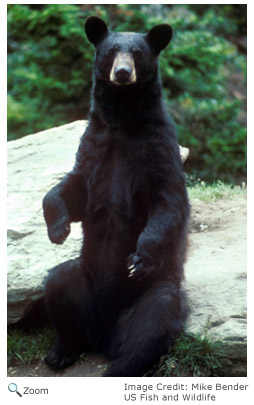

In [26]:
img = open_image(path/'black'/'00000021.jpg')
img



We create our Learner in production enviromnent like this, just make sure that path contains the file 'export.pkl' from before.


In [27]:
learner = load_learner(path) # This is what loads the .pkl file with model, weights and metadata

In [28]:
pred_class,pred_idx,outputs = learner.predict(img)
pred_class

Category black

In [29]:
# To better understand the predicitons
outputs, learner.data.classes

(tensor([9.9990e-01, 9.7395e-05, 2.0847e-07, 1.4804e-07]),
 ['black', 'grizzly', 'polar', 'teddy'])

So you might create a route something like this (thanks to Simon Willison for the structure of this code):

```python
@app.route("/classify-url", methods=["GET"])
async def classify_url(request):
    bytes = await get_bytes(request.query_params["url"])
    img = open_image(BytesIO(bytes))
    _,_,losses = learner.predict(img)
    return JSONResponse({
        "predictions": sorted(
            zip(learner.data.classes, map(float, losses)),
            key=lambda p: p[1],
            reverse=True
        )
    })
```
(This example is for the [Starlette](https://www.starlette.io/) web app toolkit.) - [Flask](https://palletsprojects.com/p/flask/) works as well but doesn't have await

You can serve that at [pythonanywhere](https://www.pythonanywhere.com/) for example